## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.9]
redice_lr_patient = [3,5,10]

In [8]:
import itertools
from keras.callbacks import ReduceLROnPlateau 
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau( factor =reduce_factor,
                                patient =reduce_patient,
                                monitor='val_loss',
                                min_lr = 1e-12,
                                verbose = 1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0727 00:47:17.414588 23128 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 00:47:17.415588 23128 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 00:47:17.417587 23128 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 00:47:17.497617 23128 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 3


W0727 00:47:17.725617 23128 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 00:47:17.732590 23128 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0727 00:47:17.821587 23128 deprecation.py:323] From C:\Users\user1\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 3s 69us/step - loss: 1.2312 - acc: 0.5708 - val_loss: 1.4808 - val_acc: 0.4815
Epoch 15/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.2088 - acc: 0.5812 - val_loss: 1.4742 - val_acc: 0.4784
Epoch 16/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.1882 - acc: 0.5871 - val_loss: 1.4703 - val_acc: 0.4876
Epoch 17/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.1680 - acc: 0.5957 - val_loss: 1.4589 - val_acc: 0.4888
Epoch 18/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.1479 - acc: 0.6023 - val_loss: 1.4522 - val_acc: 0.4882
Epoch 19/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.1288 - acc: 0.6093 - val_loss: 1.4608 - val_acc: 0.4896
Epoch 20/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.1128 - acc: 0.6168 - val_loss: 1.4496 - val_acc: 0.4928
Epoch 21/25
50000/50000 [=====================

Epoch 2/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.7481 - acc: 0.3896 - val_loss: 1.8768 - val_acc: 0.3640
Epoch 3/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.6218 - acc: 0.4301 - val_loss: 1.7206 - val_acc: 0.4017
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5501 - acc: 0.4556 - val_loss: 1.6342 - val_acc: 0.4294
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4977 - acc: 0.4759 - val_loss: 1.5928 - val_acc: 0.4402
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4552 - acc: 0.4890 - val_loss: 1.5553 - val_acc: 0.4518
Epoch 7/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4170 - acc: 0.5025 - val_loss: 1.5641 - val_acc: 0.4477
Epoch 8/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.3844 - acc: 0.5159 - val_loss: 1.5374 - val_acc: 0.4602
Epoch 9/25
50000/50000 [=================

50000/50000 [==============================] - 3s 69us/step - loss: 1.0448 - acc: 0.6456 - val_loss: 1.4422 - val_acc: 0.5013
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)  

Epoch 13/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.2565 - acc: 0.5642 - val_loss: 1.4785 - val_acc: 0.4836
Epoch 14/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2366 - acc: 0.5720 - val_loss: 1.4661 - val_acc: 0.4850
Epoch 15/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2157 - acc: 0.5794 - val_loss: 1.4567 - val_acc: 0.4894
Epoch 16/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.1962 - acc: 0.5849 - val_loss: 1.4512 - val_acc: 0.4890
Epoch 17/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.1773 - acc: 0.5927 - val_loss: 1.4432 - val_acc: 0.4912
Epoch 18/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1590 - acc: 0.6002 - val_loss: 1.4496 - val_acc: 0.4890
Epoch 19/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1407 - acc: 0.6074 - val_loss: 1.4460 - val_acc: 0.4920
Epoch 20/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 97us/step - loss: 2.2360 - acc: 0.2649 - val_loss: 2.1266 - val_acc: 0.3037
Epoch 2/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.7703 - acc: 0.3829 - val_loss: 1.8925 - val_acc: 0.3518
Epoch 3/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.6368 - acc: 0.4278 - val_loss: 1.7447 - val_acc: 0.3932
Epoch 4/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.5639 - acc: 0.4511 - val_loss: 1.6434 - val_acc: 0.4214
Epoch 5/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.5076 - acc: 0.4739 - val_loss: 1.6161 - val_acc: 0.4364
Epoch 6/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.4627 - acc: 0.4891 - val_loss: 1.5660 - val_acc: 0.4508
Epoch 7/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4238 - acc: 0.5012 - val_loss: 1.5642 - val_acc

50000/50000 [==============================] - 4s 74us/step - loss: 0.3392 - acc: 0.9104 - val_loss: 1.5874 - val_acc: 0.5249
Epoch 24/25
50000/50000 [==============================] - 4s 74us/step - loss: 0.3231 - acc: 0.9172 - val_loss: 1.6285 - val_acc: 0.5231
Epoch 25/25
50000/50000 [==============================] - 4s 74us/step - loss: 0.3100 - acc: 0.9203 - val_loss: 1.6540 - val_acc: 0.5214
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_laye

50000/50000 [==============================] - 4s 75us/step - loss: 1.2394 - acc: 0.5723 - val_loss: 1.4554 - val_acc: 0.4797
Epoch 11/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.2152 - acc: 0.5828 - val_loss: 1.4353 - val_acc: 0.4968
Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.1954 - acc: 0.5883 - val_loss: 1.4569 - val_acc: 0.4876
Epoch 13/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1746 - acc: 0.5970 - val_loss: 1.4384 - val_acc: 0.4944
Epoch 14/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.1548 - acc: 0.6052 - val_loss: 1.4538 - val_acc: 0.4869
Epoch 15/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.1381 - acc: 0.6087 - val_loss: 1.4181 - val_acc: 0.4991
Epoch 16/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.1214 - acc: 0.6172 - val_loss: 1.4327 - val_acc: 0.4939
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.9507 - acc: 0.3346 - val_loss: 2.0158 - val_acc: 0.3392
Epoch 2/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.6013 - acc: 0.4409 - val_loss: 1.7164 - val_acc: 0.4181
Epoch 3/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.5019 - acc: 0.4748 - val_loss: 1.6090 - val_acc: 0.4358
Epoch 4/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.4393 - acc: 0.4972 - val_loss: 1.5558 - val_acc: 0.4530
Epoch 5/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.3912 - acc: 0.5147 - val_loss: 1.5795 - val_acc: 0.4519
Epoch 6/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.3534 - acc: 0.5276 - val_loss: 1.5310 - val_acc: 0.4595
Epoch 7/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.3193 - acc: 0.5411 - val_loss: 1.4945 - val_ac

50000/50000 [==============================] - 4s 76us/step - loss: 0.9941 - acc: 0.6669 - val_loss: 1.4202 - val_acc: 0.5042
Epoch 25/25
50000/50000 [==============================] - 4s 76us/step - loss: 0.9829 - acc: 0.6705 - val_loss: 1.4035 - val_acc: 0.5061
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1971 - acc: 0.5868 - val_loss: 1.4669 - val_acc: 0.4820
Epoch 13/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1766 - acc: 0.5942 - val_loss: 1.4658 - val_acc: 0.4833
Epoch 14/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1559 - acc: 0.6022 - val_loss: 1.4602 - val_acc: 0.4866
Epoch 15/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1401 - acc: 0.6086 - val_loss: 1.4605 - val_acc: 0.4865
Epoch 16/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.1235 - acc: 0.6161 - val_loss: 1.4455 - val_acc: 0.4985
Epoch 17/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1082 - acc: 0.6214 - val_loss: 1.4450 - val_acc: 0.4983
Epoch 18/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.0920 - acc: 0.6274 - val_loss: 1.4375 - val_acc: 0.4998
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.8448 - acc: 0.3668 - val_loss: 2.2155 - val_acc: 0.3148
Epoch 2/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5411 - acc: 0.4538 - val_loss: 2.1218 - val_acc: 0.3387
Epoch 3/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4281 - acc: 0.4946 - val_loss: 2.5318 - val_acc: 0.2382
Epoch 4/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.3464 - acc: 0.5247 - val_loss: 2.5307 - val_acc: 0.2815
Epoch 5/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2740 - acc: 0.5506 - val_loss: 2.1084 - val_acc: 0.3377
Epoch 6/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2215 - acc: 0.5702 - val_loss: 1.8985 - val_acc: 0.3863
Epoch 7/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1755 - acc: 0.5855 - val_loss: 2.5014 - val_ac

50000/50000 [==============================] - 4s 80us/step - loss: 0.7087 - acc: 0.7784 - val_loss: 1.3985 - val_acc: 0.5251
Epoch 24/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.6982 - acc: 0.7816 - val_loss: 1.4041 - val_acc: 0.5197
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.6912 - acc: 0.7857 - val_loss: 1.4437 - val_acc: 0.5126
Numbers of exp: 20, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

Epoch 11/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3866 - acc: 0.5181 - val_loss: 1.5767 - val_acc: 0.4488
Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3621 - acc: 0.5282 - val_loss: 1.5569 - val_acc: 0.4606
Epoch 13/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3401 - acc: 0.5373 - val_loss: 1.5691 - val_acc: 0.4549
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3174 - acc: 0.5432 - val_loss: 1.5384 - val_acc: 0.4602
Epoch 15/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2967 - acc: 0.5506 - val_loss: 1.5569 - val_acc: 0.4611
Epoch 16/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2783 - acc: 0.5573 - val_loss: 1.5262 - val_acc: 0.4641
Epoch 17/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2579 - acc: 0.5673 - val_loss: 1.5453 - val_acc: 0.4636
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.2270 - acc: 0.2660 - val_loss: 2.0745 - val_acc: 0.3094
Epoch 2/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8746 - acc: 0.3559 - val_loss: 1.9214 - val_acc: 0.3445
Epoch 3/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.7405 - acc: 0.3980 - val_loss: 1.8295 - val_acc: 0.3742
Epoch 4/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6568 - acc: 0.4241 - val_loss: 1.7575 - val_acc: 0.3916
Epoch 5/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5971 - acc: 0.4429 - val_loss: 1.7164 - val_acc: 0.4082
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5471 - acc: 0.4603 - val_loss: 1.6685 - val_acc: 0.4250
Epoch 7/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5048 - acc: 0.4766 - val_loss: 1.6294 - val_ac

50000/50000 [==============================] - 4s 81us/step - loss: 1.1514 - acc: 0.6070 - val_loss: 1.5046 - val_acc: 0.4777
Epoch 25/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1374 - acc: 0.6131 - val_loss: 1.5003 - val_acc: 0.4822
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.3623 - acc: 0.5261 - val_loss: 1.5531 - val_acc: 0.4563
Epoch 13/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.3386 - acc: 0.5341 - val_loss: 1.5519 - val_acc: 0.4564
Epoch 14/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.3172 - acc: 0.5420 - val_loss: 1.5290 - val_acc: 0.4633
Epoch 15/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.2972 - acc: 0.5490 - val_loss: 1.5435 - val_acc: 0.4666
Epoch 16/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.2779 - acc: 0.5558 - val_loss: 1.5357 - val_acc: 0.4586
Epoch 17/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2590 - acc: 0.5634 - val_loss: 1.5215 - val_acc: 0.4678
Epoch 18/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.2413 - acc: 0.5709 - val_loss: 1.5332 - val_acc: 0.4645
Epoch 19/25
50000/50000 [=========

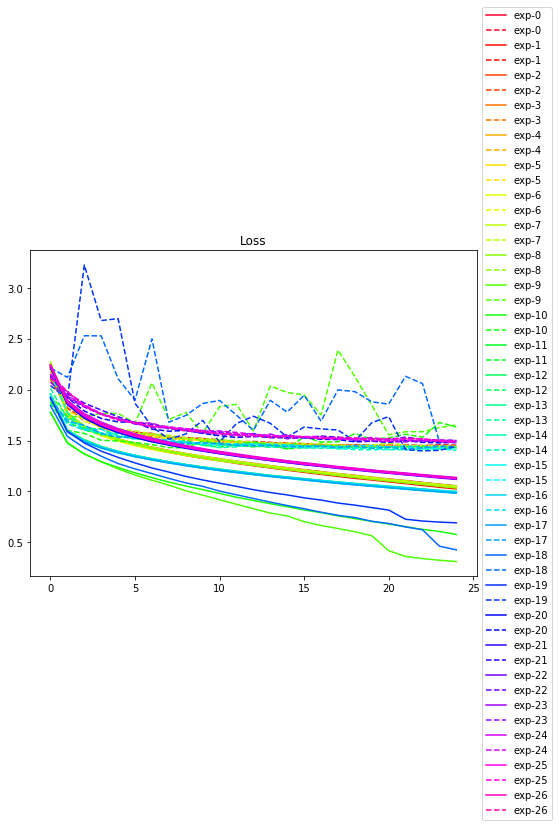

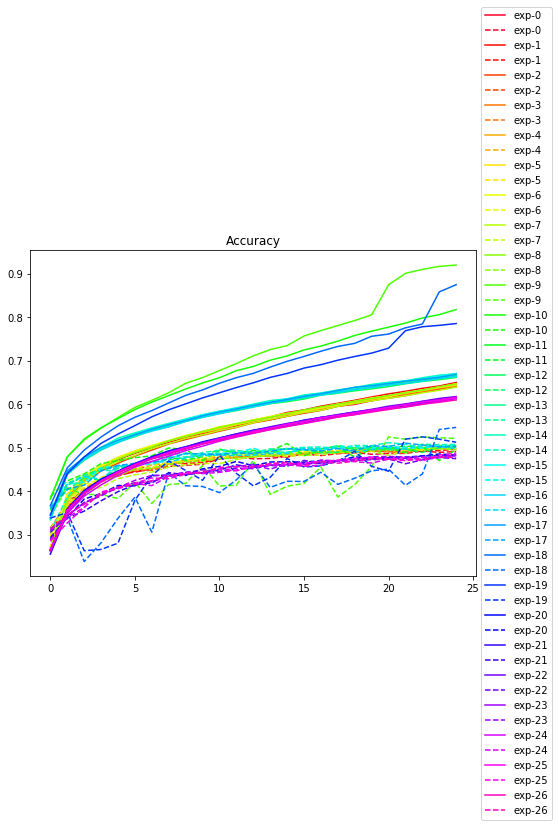

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()